In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SentimentAnalysis

Mounted at /content/drive
/content/drive/MyDrive/SentimentAnalysis


### Install and import libraries

In [2]:
!pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 44.2 MB/s eta 0:00:00


In [11]:
!pip install underthesea

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 65.3 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load datasets

In [5]:
data_train = pd.read_csv("datasets/vlsp_sentiment_train.csv", sep='\t')
data_train.columns =['Class', 'Data']
data_test = pd.read_csv("datasets/vlsp_sentiment_test.csv", sep='\t')
data_test.columns =['Class', 'Data']

In [6]:
print(data_train.shape)
print(data_test.shape)

(5100, 2)
(1050, 2)


In [7]:
data_train.sample(10)

,Class,Data
1117,-1,3tr6 thì mua dk đầy loa ngon nghe cho laptop d...
4235,0,Giống như e đẹp SF1 of OBi
1696,-1,"hầu như người bán họ đều nói ko việc gì cả,ngo..."
3786,0,Miband của mình xài 3 tháng mới sạc pin 1 lần ...
3704,0,Cho em hỏi khả năng chống nước thực sự của nó ...
3982,0,Chán nhỉ.bộ máy hơn 2 chục củ mà lệch ...
4442,0,Miếng dán kính cường lực sẽ bị ế vì màn hình c...
2806,1,Không thích dùng android chứ không thì mình cũ...
2055,1,Có ra hay không để người ta biết còn mua a sam...
3966,0,Ngoài lề hỏi các bác chút Cty e mới sắ...


<Axes: >

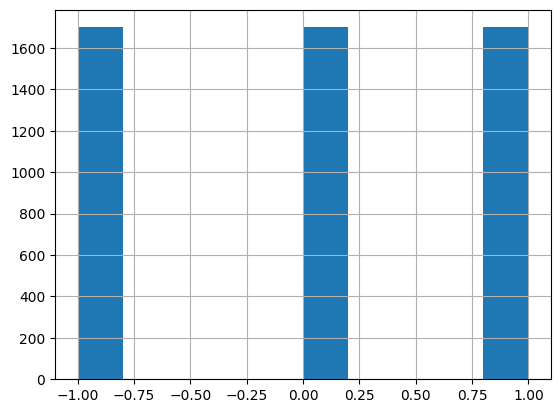

In [8]:
data_train['Class'].hist()

### Preprocess

In [9]:
def encode_label(labels):
  encoded_labels = []

  for label in labels:
    if label == -1:
        encoded_labels.append([1,0,0])
    elif label == 0:
        encoded_labels.append([0,1,0])
    else:
        encoded_labels.append([0,0,1])

  return np.array(encoded_labels)

encoded_labels = encode_label(data_train['Class'].values)
encoded_labels

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [12]:
# Normalize text using Underthesea
from underthesea import text_normalize

def normalize(text):
  return text_normalize(text)

# text = "Không nên mua chuột cua Logitech, vì dùng nó rất khó đổi cái mới. Mình nghe thằng bạn xúi mua con M325 cách đây 5 năm, dù có cơ số lần rơi rớt quăng quật mà đến giờ vẫn chưa hư. Giờ đang thèm em MX Anywhere 2 này mà chuột cũ chưa hư sao mua chuột mới!"
# print(normalize(text))

In [13]:
# Remove url
import re

def remove_urls(text):
    url_pattern = re.compile(r'(http|https)://[^\s]+')
    cleaned_text = re.sub(url_pattern, '', text)

    return cleaned_text

In [14]:
# Remove digits
from string import digits

def remove_digits(text):
    cleaned_text = ''.join([char for char in text if char not in digits])
    return cleaned_text

In [15]:
# Remove duplicate punctuation
def remove_dup_punctuation(text):
  text.replace('...', '')
  cleaned_text = re.sub(r'([^\w\s])\1+', r'\1', text)

  return cleaned_text

In [16]:
# Remove duplicate
def remove_dup_char(text):
  text = re.sub(r'([a-z])\1+', lambda m: m.group(1), text, flags=re.IGNORECASE)
  text = re.sub(r'([a-z][a-z])\1+', lambda m: m.group(1), text, flags=re.IGNORECASE)

  return text

In [40]:
# Use PyVi for Vietnamese word tokenizer
from pyvi import ViTokenizer

def tokenize(text):
  text = ViTokenizer.tokenize(text.lower())
  return text.split(' ')

In [41]:
# use underthesea to tokenize
from underthesea import word_tokenize

def under_tokenize(text):
  return word_tokenize(text)

sentence = 'Chàng trai 9X Quảng Trị khởi nghiệp từ nấm sò'
word_tokenize(sentence)

['Chàng', 'trai', '9X', 'Quảng Trị', 'khởi nghiệp', 'từ', 'nấm', 'sò']

In [42]:
# Combine all processing
def preprocess(text):
  text = normalize(text)
  text = remove_urls(text)
  text = remove_digits(text)
  text = remove_dup_punctuation(text)
  text = remove_dup_char(text)
  tokens = tokenize(text)

  return tokens

In [43]:
data_train['Processed_data'] = data_train['Data'].apply(lambda x: preprocess(x))
data_test['Processed_data'] = data_test['Data'].apply(lambda x: preprocess(x))

In [44]:
from random import randint

INDEX = randint(0, len(data_train['Data']))
print(data_train['Data'].tolist()[INDEX], sep="")
print(data_train['Processed_data'].to_list()[INDEX], sep="")

Sản phẩm này là bằng chứng để có thể đoán được hãng này đang rơi vào thời kỳ khó khăn khi đánh đổi lợi nhuận để lấy lại thị phần
['sản_phẩm', 'này', 'là', 'bằng_chứng', 'để', 'có_thể', 'đoán', 'được', 'hãng', 'này', 'đang', 'rơi', 'vào', 'thời_kỳ', 'khó_khăn', 'khi', 'đánh_đổi', 'lợi_nhuận', 'để', 'lấy', 'lại', 'thị_phần']


In [45]:
word_reviews = data_train['Processed_data'].to_list()

In [46]:
EMBEDDING_DIM = 400 # how big is each word vector
MAX_VOCAB_SIZE = 10000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 300 # max number of words in a comment to use

In [47]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [48]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(word_reviews)
sequences_train = tokenizer.texts_to_sequences(word_reviews)
word_index = tokenizer.word_index

In [49]:
data = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
labels = encoded_labels

In [50]:
print('Shape of X train and validation:', data.shape)
print('Shape of label train and validation:', labels.shape)

Shape of X train and validation: (5100, 300)
Shape of label train and validation: (5100, 3)


### Embedding using Word2Vec

In [51]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('models/vi-model-CBOW.bin', binary=True)

vocabulary_size=min(len(word_index)+1,MAX_VOCAB_SIZE)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
print("Vocabulary size:", vocabulary_size)
for word, i in word_index.items():
    if i>=MAX_VOCAB_SIZE:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

Vocabulary size: 7750


### Define and train model

In [52]:
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout,concatenate
from tensorflow.keras.layers import Reshape, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
sequence_length = data.shape[1]
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

################## LSTM ONLY ###############################
reshape = Reshape((sequence_length,EMBEDDING_DIM))(embedding)
lstm_2 = LSTM(1024, return_sequences=True)(reshape)
lstm_1 = LSTM(512, return_sequences=True)(lstm_2)
lstm_0 = LSTM(256)(lstm_1)

############################################################
dropout = Dropout(drop)(lstm_0)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)


# this creates a model that includes
model = Model(inputs, output)


adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 300, 400)          3100000   
                                                                 
 reshape_3 (Reshape)         (None, 300, 400)          0         
                                                                 
 lstm_3 (LSTM)               (None, 300, 1024)         5836800   
                                                                 
 lstm_4 (LSTM)               (None, 300, 512)          3147776   
                                                                 
 lstm_5 (LSTM)               (None, 256)               787456    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0   

In [53]:
model.fit(data, labels, validation_split=0.2,
          epochs=10, batch_size=256, callbacks=[], shuffle=True)

Epoch 1/10
16/16 [==============================] - 32s 2s/step - loss: 1.2096 - accuracy: 0.4419 - val_loss: 1.9220 - val_accuracy: 0.0000e+00
Epoch 2/10
16/16 [==============================] - 26s 2s/step - loss: 0.9836 - accuracy: 0.5630 - val_loss: 1.6776 - val_accuracy: 0.0108
Epoch 3/10
16/16 [==============================] - 25s 2s/step - loss: 0.8731 - accuracy: 0.6328 - val_loss: 1.9561 - val_accuracy: 0.0088
Epoch 4/10
16/16 [==============================] - 27s 2s/step - loss: 0.7364 - accuracy: 0.7270 - val_loss: 1.6774 - val_accuracy: 0.1696
Epoch 5/10
16/16 [==============================] - 27s 2s/step - loss: 0.6166 - accuracy: 0.7740 - val_loss: 1.7514 - val_accuracy: 0.2235
Epoch 6/10
16/16 [==============================] - 26s 2s/step - loss: 0.4820 - accuracy: 0.8407 - val_loss: 2.1595 - val_accuracy: 0.1961
Epoch 7/10
16/16 [==============================] - 27s 2s/step - loss: 0.3421 - accuracy: 0.9022 - val_loss: 3.0812 - val_accuracy: 0.1451
Epoch 8/10
16/16

### Predict and evaluate results

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def calculate_metrics(X_test_scaled, Y_test,model = None):
    # Get model predictions
    if model:
       y_predict_r = model.predict(X_test_scaled)
    else:
       y_predict_r = X_test_scaled
    acc = accuracy_score(Y_test, y_predict_r)
    prec = precision_score(Y_test, y_predict_r, average='macro')
    rec = recall_score(Y_test, y_predict_r, average='macro')
    f1 = f1_score(Y_test, y_predict_r, average='macro')

    return acc, prec, rec, f1

def get_metrics(X_test, Y_test, model = None):
    acc, prec, rec, f1 = calculate_metrics(X_test, Y_test, model = model)
    display_df = pd.DataFrame([[acc, prec, rec, f1]], columns=["Accuracy", "Precision", "Recall", "F1 Score"])
    return display_df

In [55]:
sequences_test = tokenizer.texts_to_sequences(data_test['Processed_data'].to_list())
word_reviews_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
labels_test = encode_label(data_test['Class'].values)

In [56]:
print('Shape of X test:', word_reviews_test.shape)
print('Shape of label test:', labels_test.shape)

Shape of X test: (1050, 300)
Shape of label test: (1050, 3)


In [57]:
inference = model.predict(word_reviews_test)

33/33 [==============================] - 4s 82ms/step


In [61]:
y_hat = [np.argmax(ele) for ele in inference]
y = [np.argmax(ele) for ele in labels_test]

df = get_metrics(y_hat, y, model = None)
df.index = ['LSTM']
df.head(10)

,Accuracy,Precision,Recall,F1 Score
LSTM,0.615238,0.628837,0.615238,0.592486


Text(0.5, 3.722222222222216, 'Predicted')

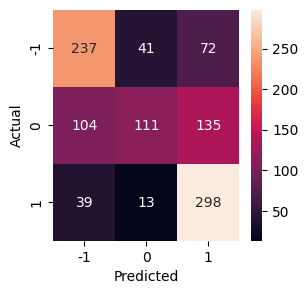

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(3, 3))
conf_mat = confusion_matrix(y, y_hat)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=[-1,0,1], yticklabels=[-1,0,1])
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [63]:
model.save_weights("LSTM.h5")
!cp LSTM.h5 /content/drive/MyDrive/SentimentAnalysis/models